In [316]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
import seaborn as sns
from datetime import datetime
import calendar
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 50)

In [2]:
df = pd.read_csv('data.csv', sep=';', index_col = ['REPORTDATE'], parse_dates=['REPORTDATE'], dayfirst=True)

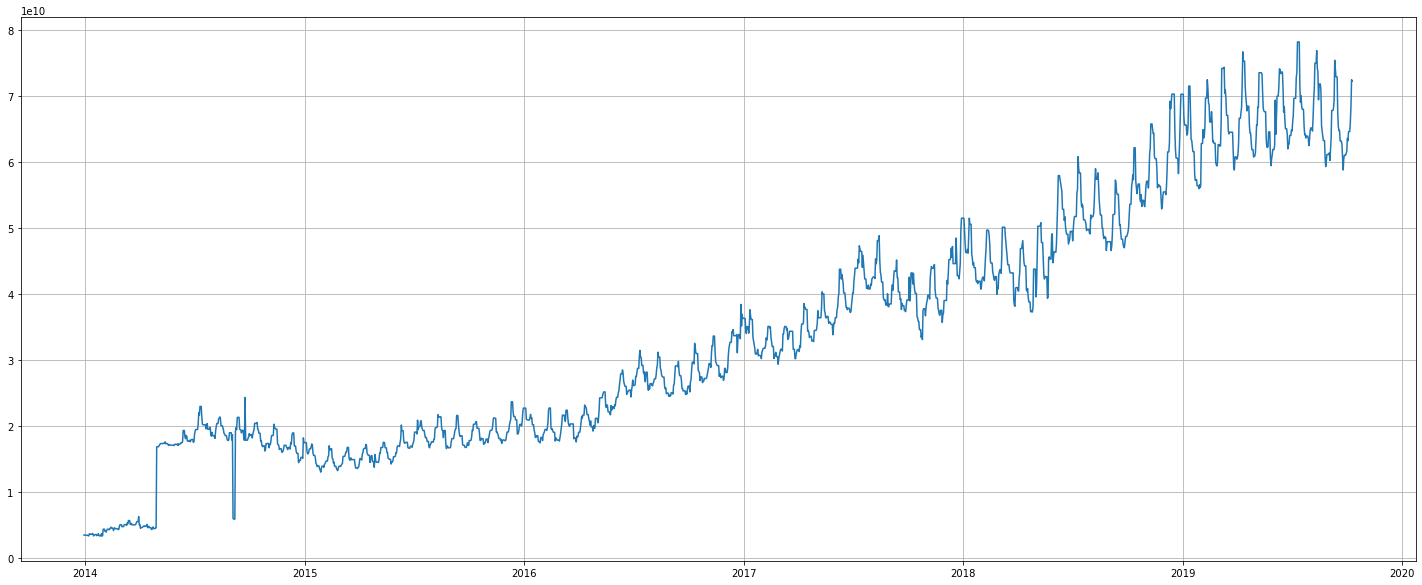

In [3]:
plt.figure(figsize=(25, 10))
plt.plot(df, label='days')
plt.grid(True)

Исходя из рекомендаций ряда исследователей по временным рядам, как правило, данные старше 5-6 лет уже не являются актуальными и полезными для прогноза. Тем более в наших данных в промежутке с 2014  по 2015 год заметен резкий скачек денежных средств на счетах, соответственно характер ряда поменялся. Также в этом промежутке есть выброс. Исходя из этого считаю что данные для модели лучше взять после 2015 года.

Попробуем прологарифмировать данные, чтобы избавиться от мультипликативной сезонности. Посмотрим график

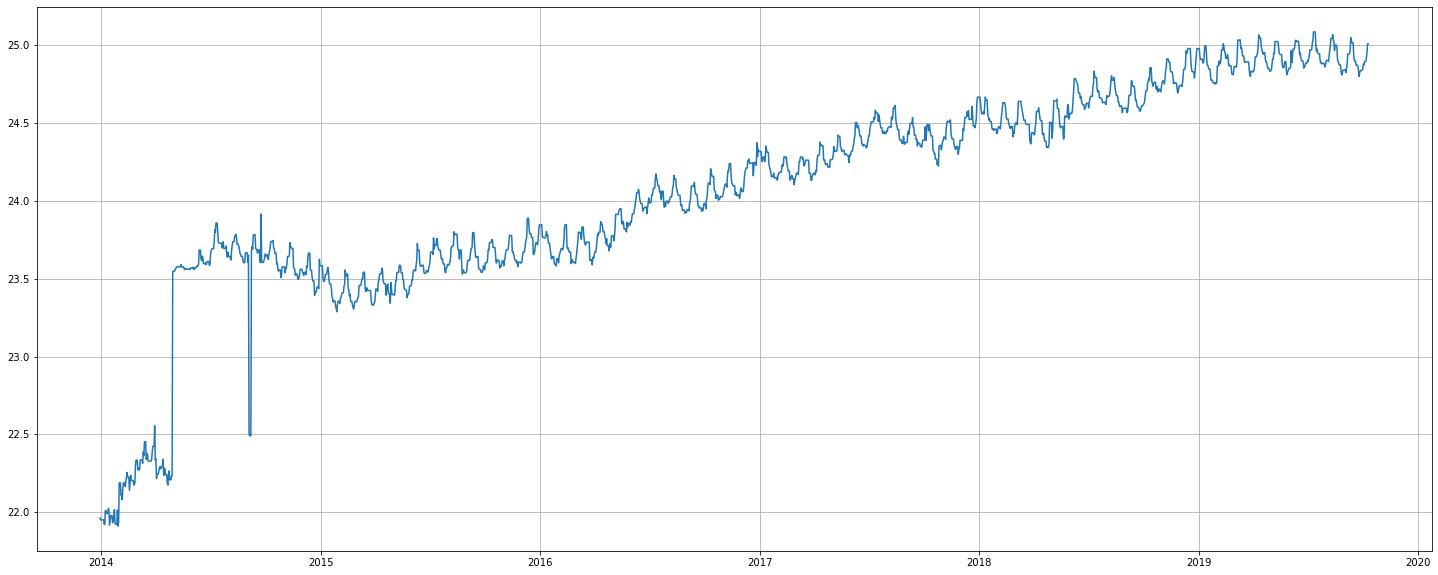

In [333]:
plt.figure(figsize=(25, 10))
plt.plot(np.log(df), label='days')
plt.grid(True)

Визуально на графике видно, что тренд как будто начинает затухать в 2019 году. Это нужно будет учесть при прогнозировании. Также видно что сезонность стала аддиктивной после логарфимирования.

In [358]:
class TimerowPredictor():
        
    def __init__(self, data):
        self.prediction = self.train_and_predict(data)
    
    def train_and_predict(self, data):
        
        """Функция(метод), прогнозирующая значение временного ряда на год вперед. Функция строит 2 прогноза: первый - строится
           на последний год представленного временного ряда, для оценки качества модели и определения приблизительного
           временного интервала; второй - итоговый прогноз на следующий год для представленного временного ряда.
           Возвращает 4 значения: предсказание для последнего года имеющихся данных; предсказание на следующий, от введенных
           данных, год; исходный временной ряд; ошибка предсказания, в процентах, полученная на имеющихся данных."""
        
        data = data.copy()
        if len(data.index)<1461:
            print('Недостаточно данных. Временной ряд должен содержать минимум 4 года наблюдений.')
            return None
        train = (data[-1461:-365]) # берем данные за последние 4 года, последний год отложим для оценки качества модели
        model = ExponentialSmoothing(
            train, trend='add', damped_trend=False, seasonal='mul', seasonal_periods=365, initialization_method='heuristic', 
            freq='D').fit()
        predict = model.predict(start=train.index[-1], end=train.index[-1]+timedelta(days=365))
        
        # модель с затухающим трендом
        model_damped = ExponentialSmoothing(
            train, trend='add', damped_trend=True, seasonal='mul', seasonal_periods=365, initialization_method='heuristic', 
            freq='D').fit()
        predict_damped = model_damped.predict(start=train.index[-1], end=train.index[-1]+timedelta(days=365))
        
        # для регрессии берем только данные за предыдущий год; логарифмируем целевую переменную, 
        # чтобы избавиться от мультипликативной сезонности
        df_reg = np.log(data[-730:-365])
        df_reg['day_num'] = range(1, len(df_reg.index)+1)
        
        # создаем столбцы с сезонными поправками для каждого дня
        for x in range(1, len(df_reg.index)+1):
            df_reg['day_'+str(x)] = df_reg['day_num']==x
        
        X = df_reg.iloc[:,1:-1].astype('int') # убираем один столбец во избежание коллинеарности
        y = df_reg['VALUE']
        X_topred = X.copy()
        X_topred['day_num'] = range(366, 731)
        X_topred = pd.concat([X, X_topred])
        model_reg = LinearRegression()
        model_reg.fit(X.values, y)
        predict_reg = model_reg.predict(X_topred.values)
        
        # создаем датафрейм с прогнозами разных моделей в качестве признаков 
        meta_data = pd.DataFrame(index = df.index[-365:])
        meta_data['regression'] = np.exp(predict_reg[-365:])
        meta_data['holtwinters'] = predict[1:].values
        meta_data['holtwinters_damped'] = predict_damped[1:].values
        
        # в качестве итогового прогноза берем усредненные прогнозы трех моделей
        meta_data['meta_predict'] = meta_data.mean(axis=1)
        
        #ошибка на тренировочных данных
        error = mean_absolute_percentage_error((data[-365:].values), meta_data['meta_predict'].values)
        
        # повторяем то же самое, но уже для полных данных
        final_train = data[-1461:]
        final_model = ExponentialSmoothing(
            final_train, trend='add', damped_trend=False, seasonal='mul', seasonal_periods=365, initialization_method='heuristic', 
            freq='D').fit()
        final_predict = final_model.predict(start=final_train.index[-1], end=final_train.index[-1]+timedelta(days=365))
        final_model_damped = ExponentialSmoothing(
            final_train, trend='add', damped_trend=True, seasonal='mul', seasonal_periods=365, initialization_method='heuristic', 
            freq='D').fit()
        final_predict_damped = final_model_damped.predict(start=final_train.index[-1], end=final_train.index[-1]+timedelta(days=365))
        final_df_reg = np.log(data[-365:])
        final_df_reg['day_num'] = range(1, len(final_df_reg.index)+1)
        for x in range(1, len(final_df_reg.index)+1):
            final_df_reg['day_'+str(x)] = final_df_reg['day_num']==x
        final_X = final_df_reg.iloc[:,1:-1].astype('int')
        final_y = final_df_reg['VALUE']
        final_X_topred = final_X.copy()
        final_X_topred['day_num'] = range(len(final_df_reg.index)+1, len(final_df_reg.index)+366)
        final_X_topred = pd.concat([final_X, final_X_topred])
        final_model_reg = LinearRegression()
        final_model_reg.fit(final_X.values, final_y)
        final_predict_reg = final_model_reg.predict(final_X_topred.values)
        final_meta_data = pd.DataFrame(index = pd.date_range(start=data.index[-1]+timedelta(days=1), end=data.index[-1]+timedelta(days=365)))
        final_meta_data['regression'] = np.exp(final_predict_reg[-365:])
        final_meta_data['holtwinters'] = final_predict[1:].values
        final_meta_data['holtwinters_damped'] = final_predict_damped[1:].values
        final_meta_data['meta_predict'] = final_meta_data.mean(axis=1)
        return meta_data['meta_predict'], final_meta_data['meta_predict'], data, error
  
    
    def prediction_plot(self):
        
        """Функция(метод) для отрисовки графика предсказанных моделью значений временного ряда"""
        
        plt.figure(figsize=(25, 10))
        plt.plot(self.prediction[1], label='predicted')
        plt.plot(self.prediction[2], label='true')
        plt.legend(loc='best', fontsize='x-large')
        plt.grid(True)
    
    
    def train_plot(self):
        
        """Функция(метод) строит график прогноза на данных с отложенной тестовой выборкой. Позволяет визуально оценить
           качество модели для прогнозирования в сравнении с реальными данными."""
        
        plt.figure(figsize=(25, 10))
        plt.plot(self.prediction[0], label='predicted')
        plt.plot(self.prediction[2], label='true')
        plt.legend(loc='best', fontsize='x-large')
        plt.grid(True)
        print(f'Средняя абсолютная ошибка на тренировочных данных составила {round(self.prediction[3]*100, 2)}%')
    
    
    def predicted_values(self):
        
        """Функция(метод) возвращает предсказанные значения в виде Series."""
        
        return self.prediction[1]
    
    
    def predicted_train_values(self):
        
        """Функция(метод) возвращает предсказанные на тренировочных данных значения в виде Series."""
        
        return self.prediction[0]

In [362]:
test_model = TimerowPredictor(df)

Средняя абсолютная ошибка на тренировочных данных составила 4.91%


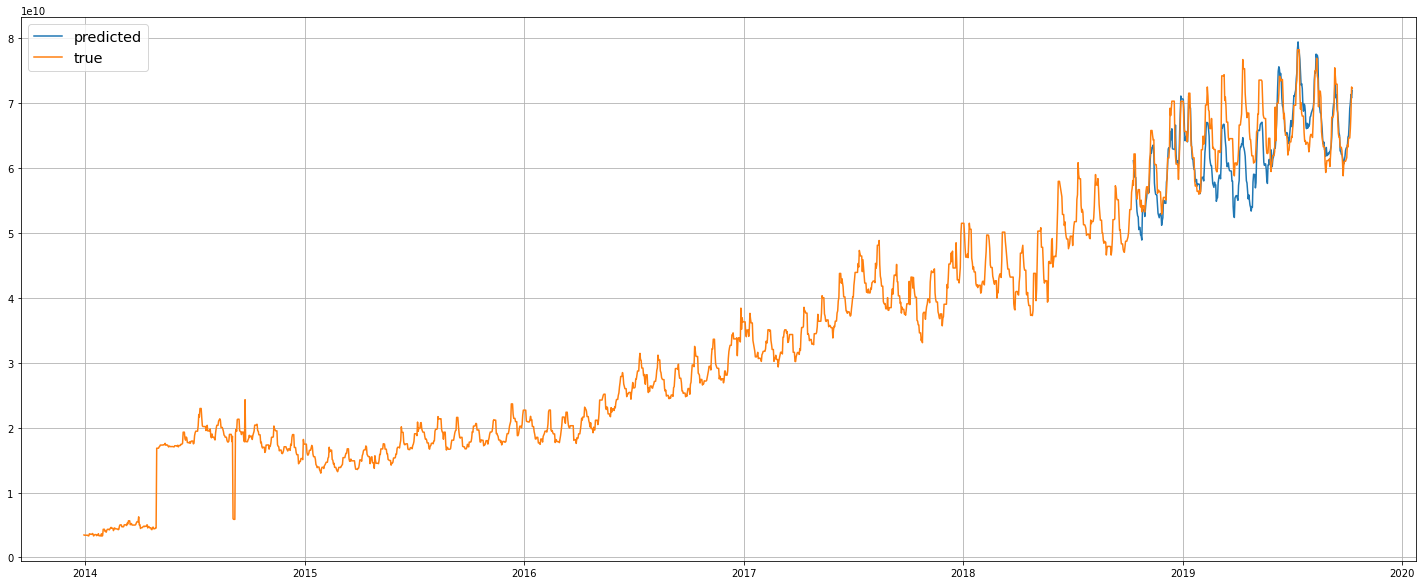

In [363]:
test_model.train_plot()

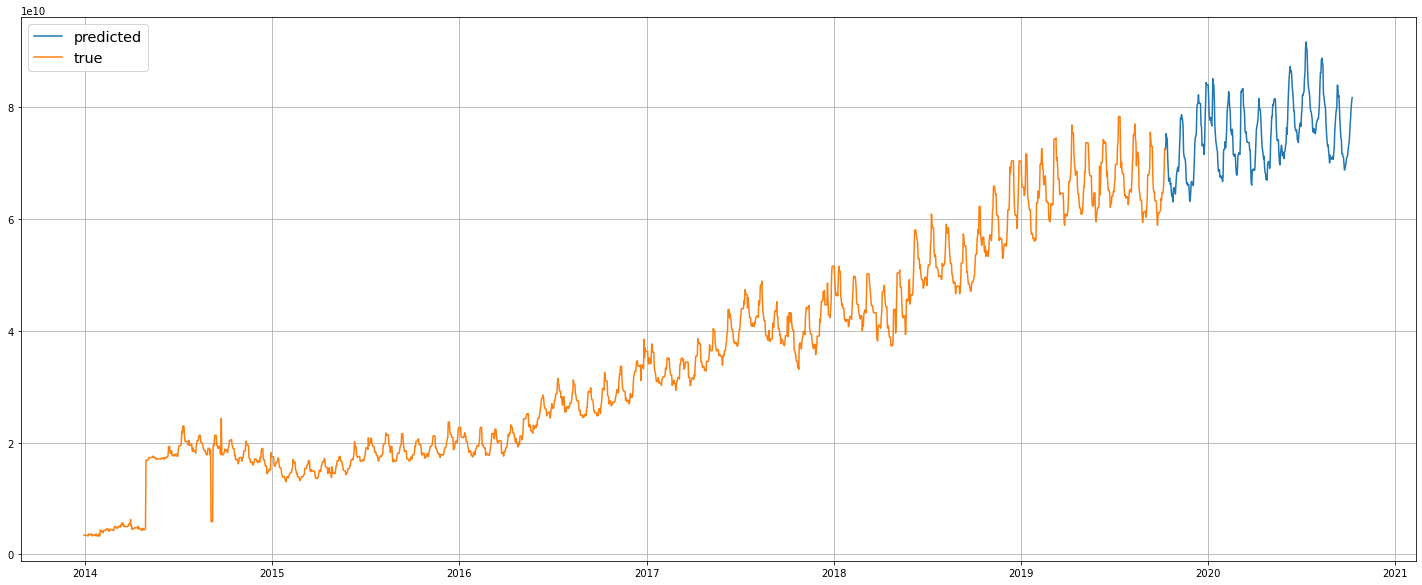

In [329]:
test_model.prediction_plot()

In [330]:
test_model.predicted_values()

2019-10-11    7.256833e+10
2019-10-12    7.518575e+10
2019-10-13    7.442472e+10
2019-10-14    7.433778e+10
2019-10-15    7.078209e+10
                  ...     
2020-10-05    7.679079e+10
2020-10-06    7.804870e+10
2020-10-07    7.975418e+10
2020-10-08    8.088593e+10
2020-10-09    8.162052e+10
Freq: D, Name: meta_predict, Length: 365, dtype: float64

In [331]:
test_model.predicted_train_values()

REPORTDATE
2018-10-11    6.113141e+10
2018-10-12    5.982307e+10
2018-10-13    5.864246e+10
2018-10-14    5.856697e+10
2018-10-15    5.853926e+10
                  ...     
2019-10-06    6.919412e+10
2019-10-07    7.000416e+10
2019-10-08    7.133966e+10
2019-10-09    7.080099e+10
2019-10-10    7.198163e+10
Name: meta_predict, Length: 365, dtype: float64

In [353]:
df.iloc[4461]

IndexError: single positional indexer is out-of-bounds